## Background

The task involves the creation of a backtesting software to evaluate the performance of a specified set of stocks known as the "Magnificent 7" (Microsoft [MSFT], Apple [AAPL], Nvidia [NVDA], Amazon [AMZN], Google [GOOG], Meta [META], Tesla [TSLA]) in the US stock market. The program should employ the Double Bollinger Bands strategy as the basis for trading signals or any other strategy that you deem more applicable. For further details on this strategy, refer to the comprehensive guide available at (https://www.3candlereversal.com/post/kathy-lien-s-double-bollinger-band-strategy).  



In [1]:
!pip install yfinance
!pip install ta
!pip install requests_cache


[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

In [3]:
class Magnificent7():
    def __init__(self, symbol, start, end, interval, capital, verbose = True):
        self.all_data = {}
        self.position = {}
        self.quantity = {}
        self.position_history = {} # records the position taken for each stock daily

        for stock in symbol:
            self.quantity['{}'.format(stock)]  = 0

        self.symbol = symbol
        self.start = start
        self.end = end
        self.interval = interval
        self.initial_capital = capital
        self.capital = capital
        self.trades = 0
        self.verbose = verbose
        self.daily_perf = pd.DataFrame(columns = ['date', 'realised_balance', 'unrealised_balance', 'total_balance'])
        
        self.prepare_data()

    def prepare_data(self):
        for stock in self.symbol:
            hist_stock = yf.download(stock, start = self.start, end = self.end, interval = self.interval)
            data = pd.DataFrame()
            data['Adj_Close'] = hist_stock['Adj Close']
            self.all_data['{}'.format(stock)] = data 
            self.position['{}'.format(stock)] = 0

    def return_date_price(self, bar, stock):
        date = str(self.all_data[str(stock)].index[bar])[:10]
        price = self.all_data[str(stock)]['Adj_Close'].iloc[bar]
        return date, price

    def realised_balance(self, bar):
        date, price = self.return_date_price(bar, self.symbol[0]) 
        print("Date :{} | Realised Balance: {:0.1f}".format(date,self.capital))

    def unrealised_balance(self, bar):
        ub = 0
        for stock in self.symbol:
            date, price = self.return_date_price(bar, stock)
            ub =  ub + self.quantity['{}'.format(stock)] *price
        print("Date :{} | Unrealised Balance: {:0.1f}".format(date,ub))

    def total_balance(self, bar):
        ub = 0
        for stock in self.symbol:
            date, price = self.return_date_price(bar, stock)
            ub =  ub + self.quantity['{}'.format(stock)] *price

        tb = ub + self.capital
        print("Date :{} | Total Balance: {:0.1f}".format(date,tb))

    def buy_order(self, bar, stock, quantity = None, dollar = None):
        date, price = self.return_date_price(bar, stock)
        if quantity == None:
            quantity = int(dollar/price)
        self.capital = self.capital - (quantity * price)
        self.quantity[stock] = self.quantity[stock] + quantity
        self.trades = self.trades + 1
        if self.verbose:
            print("Bought {} shares of {} at {:0.1f} per share worth {:0.1f} $".format(quantity, stock, price, quantity * price))
            print('Total quantity for {} is {}'.format(stock,self.quantity['{}'.format(stock)]))
            self.realised_balance(bar)
            self.unrealised_balance(bar)
            self.total_balance(bar)

    def sell_order(self, bar, stock, quantity = None, dollar = None):
        date, price = self.return_date_price(bar, stock)
        if quantity == None:
            quantity = int(dollar/price)
        self.capital = self.capital + (quantity * price)
        self.quantity[stock] = self.quantity[stock] - quantity
        self.trades = self.trades + 1
        if self.verbose:
            print("Sold {} shares of {} at {:0.1f} per share worth {:0.1f} $".format(quantity,stock, price, quantity * price))
            print('Total quantity for {} is {}'.format(stock,self.quantity['{}'.format(stock)]))
            self.realised_balance(bar)
            self.unrealised_balance(bar)
            self.total_balance(bar)

    def last_trade(self, bar):
        last_quantity = 0
        for k in self.quantity.keys():
            date, price = self.return_date_price(bar, k)
            qty = self.quantity[k]
            last_quantity += qty
            self.capital = self.capital + qty * price
            self.quantity[k] = 0
            self.trades = self.trades + 1
            if self.verbose:
                print("Closed open trades for {} shares of {} at {:0.1f} per share worth {:0.1f} $".format(last_quantity,k, price, last_quantity * price))

        if self.verbose:
            self.total_balance(bar)
            returns = (self.capital - self.initial_capital) /self.initial_capital *100
            print("The total capital at end of strategy: {:0.1f}".format(self.capital))
            print( "The strategy returns (final - initial capital) on investment are {:0.1f} %".format(returns))
            print( "Total trades by startegy are {:0.1f}".format(self.trades))

    def print_dailypref(self):
        return self.daily_perf
    
    def performance(self):
        # Metrics:
        # 1. Total Return
        # 2. Annual Return
        # 3. Annual Volatiliy
        # 4. Sharpe Ratio
        # 5. Sortino Ratio
        # 6. Maximum Drawdown
        
        self.daily_perf["daily_log_ret"] = np.log(self.daily_perf["total_balance"] / self.daily_perf["total_balance"].shift(1))

        total_returns = (self.capital - self.initial_capital) /self.initial_capital *100
        print("Total returns of the Double Bollinger Bands Strategy is {:0.1f}%".format(total_returns))

        annual_returns = self.daily_perf["daily_log_ret"].mean() * 252 
        annual_reg_returns = (np.exp(annual_returns)-1) * 100
        print("Annual log returns is {:0.2f}".format(annual_returns))
        print("Annual regular returns is {:0.2f}%".format(annual_reg_returns))

        annual_volatility = self.daily_perf["daily_log_ret"].std() * (252 **0.5)
        annual_reg_volatility = (np.exp(self.daily_perf["daily_log_ret"])-1).std() * (252 **0.5) * 100
        print("Annual log volatiltiy is {:0.2f}".format(annual_volatility))
        print("Annual regular volatiltiy is {:0.2f}%".format(annual_reg_volatility))

        sharpe_ratio = annual_reg_returns / annual_reg_volatility
        print("The Sharpe Ratio of the strategy is {:0.2f}".format(sharpe_ratio))

        negative_returns = self.daily_perf['daily_log_ret'].apply(lambda x: 0 if x > 0 else x)
        negative_reg_returns = np.exp(negative_returns) - 1
        annual_neg_sd = negative_reg_returns.std() * (252 ** 0.5) * 100
        sortino_ratio = annual_reg_returns/annual_neg_sd
        print("The Sortino Ratio of the strategy is {:0.2f}".format(sortino_ratio))

        self.daily_perf["cum_max"] = self.daily_perf["daily_log_ret"].cumsum().cummax()
        self.daily_perf["drawdown"] = self.daily_perf["cum_max"] - self.daily_perf["daily_log_ret"].cumsum()
        Max_Drawdown = self.daily_perf["drawdown"].max()*100
        print("The maximum drawdown: {:.2f}%".format(Max_Drawdown))
        

class DoubleBollingerBand_Strategy(Magnificent7):
    def go_long(self, bar, stock, position_size):
        if self.position[stock] == -1: #previous position is short, so buy back all the shares to clear short
            self.buy_order(bar, stock, quantity = -self.quantity[stock])
        # position_size is the percentage of available capital that we want to made trade with
        dollar = self.capital * position_size
        self.buy_order(bar, stock, dollar = dollar)

    def go_short(self, bar, stock, position_size):
        if self.position[stock] == 1: #previous position is long, so sell off all shares on hand
            self.sell_order(bar, stock, quantity=self.quantity[stock])
        # position_size is the percentage of available capital that we want to made trade with
        dollar = self.capital * position_size
        self.sell_order(bar, stock, dollar=dollar)

    def run_strategy(self, MA_window, BB1_deviation, BB2_deviation, position_size):
        self.position = {}
        self.trades = 0
        self.capital = self.initial_capital
        for stock in self.symbol:
            self.position[stock] = 0

        num_stocks = len(self.position)
        data_length = 0
        for stock in self.symbol:
            moving_average = self.all_data[stock]['Adj_Close'].rolling(window=MA_window).mean()
            moving_std = self.all_data[stock]['Adj_Close'].rolling(window=MA_window).std()
            upper_band_1 = moving_average + (moving_std * BB1_deviation)
            lower_band_1 = moving_average - (moving_std * BB1_deviation)
            upper_band_2 = moving_average + (moving_std * BB2_deviation)
            lower_band_2 = moving_average - (moving_std * BB2_deviation)

            self.all_data[stock]['MA'] = moving_average
            self.all_data[stock]['UpperBand2'] = upper_band_2
            self.all_data[stock]['UpperBand1'] = upper_band_1
            self.all_data[stock]['LowerBand1'] = lower_band_1
            self.all_data[stock]['LowerBand2'] = lower_band_2
            self.position_history[stock] = []
            data_length = len(self.all_data[stock])

        for bar in range(MA_window-1, data_length):
            for stock in self.symbol:
                date, price = self.return_date_price(bar, stock)
                
                # print(date, '   ', self.capital) --> print the daily realised balance
                max_dollar = self.capital * (1/num_stocks)
                if self.position[stock] in [0,-1]:
                    if (self.all_data[stock]['UpperBand2'].iloc[bar] > price) and (price > self.all_data[stock]['UpperBand1'].iloc[bar]):
                        self.go_long(bar, stock, position_size)
                        self.position[stock] = 1
                        print("--------")

                if self.position[stock] in [0, 1]:
                    if (self.all_data[stock]['LowerBand1'].iloc[bar] > price) and (price > self.all_data[stock]['LowerBand2'].iloc[bar]):
                        self.go_short(bar, stock, position_size)
                        self.position[stock] = -1
                        print("---------")
                self.position_history[stock] = self.position_history[stock] + [self.position[stock]]
            # record daily balance
            total_price = 0
            for stock in self.symbol:
                date, price = self.return_date_price(bar, stock)
                ub = self.quantity[stock] *price
                total_price += ub
                # tb = ub + self.capital
                tb = total_price + self.capital
            self.daily_perf.loc[len(self.daily_perf)] = {'date': date, 'realised_balance': self.capital,'unrealised_balance': total_price,'total_balance': tb}

        print("--------")
        self.last_trade(bar)   

## Strategy

Referring to the Double Bollinger Bands Strategy from https://www.3candlereversal.com/post/kathy-lien-s-double-bollinger-band-strategy
The strategy creates two bollinger bands of different deviations. 
The area bounded by the two upper bands is the buy zone, and likewise the area bounded by the two lower bands is the sell zone. 
The area within the inner upper and lower bands is the neutral zone.

Under the Double Bollinger Bands Strategy, we will go for a long position when price enters the buy zone.
Conversely, we will take a short position when price enters the sell zone. 
When price is the neutral, we will not take any actions, as there is no strong trend and price is likely to fluctuate.

## Assumpions

For this backtesting scenario, we assume the interval is 1 day and the prices used is the adjusted close price. 
For the strategy specifically, we set the default value for the double bollinger bands, which is a 20-period window for the moving averages and 1 and 2 deviation for the two sets of bollinger bands.
In terms of position sizing, we determine the quantity of shares to long/short through a fixed percentage of available capital. 
In this scenario, we have set the fixed percentage to be 5% of the available capital (realised balance).

In [4]:
if __name__ == "__main__":
    tickers = ['MSFT', 'AAPL', 'NVDA', 'AMZN', 'GOOG', 'META', 'TSLA']
    initial_capital = 10000
    start_date = '2013-01-01'
    end_date = '2023-12-31' 
    interval = '1d'
    A = DoubleBollingerBand_Strategy(tickers, start_date, end_date, interval, initial_capital, True)
    A.run_strategy(MA_window=20, BB1_deviation = 1, BB2_deviation = 2, position_size = 0.05) 

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Bought 22 shares of MSFT at 22.7 per share worth 499.9 $
Total quantity for MSFT is 22
Date :2013-01-30 | Realised Balance: 9500.1
Date :2013-01-30 | Unrealised Balance: 499.9
Date :2013-01-30 | Total Balance: 10000.0
--------
Sold 34 shares of AAPL at 13.9 per share worth 473.8 $
Total quantity for AAPL is -34
Date :2013-01-30 | Realised Balance: 9973.9
Date :2013-01-30 | Unrealised Balance: 26.1
Date :2013-01-30 | Total Balance: 10000.0
---------
Bought 26 shares of GOOG at 18.8 per share worth 488.2 $
Total quantity for GOOG is 26
Date :2013-01-30 | Realised Balance: 9485.8
Date :2013-01-30 | Unrealised Balance: 514.2
Date :2013-01-30 | Total Balance: 10000.0
--------
Bought 189 shares of TSLA at 2.5 per share worth 472.8 $
Total quantity for TSLA is 189
Date :2013-01-30 | Realised Balance: 9013.0
Date :2013-01-30 | Unrealised Balance: 987.0
Date :2013-01-30 | Total Balance: 10000.0
--------
Sold 34 shares of AMZN at 13.0 per share worth 442.0 $
Total quantity for AMZN is -34
Date :

In [5]:
A.performance()

Total returns of the Double Bollinger Bands Strategy is 71.2%
Annual log returns is 0.05
Annual regular returns is 5.06%
Annual log volatiltiy is 0.07
Annual regular volatiltiy is 6.83%
The Sharpe Ratio of the strategy is 0.74
The Sortino Ratio of the strategy is 1.24
The maximum drawdown: 13.32%


## Evaluation of performance

Total returns of strategy over the backtesting period is 71.2%, with an annual regular returns of 5%.
A Sharpe Ratio of 0.74 and Sortino Ratio of 1.24 are considered acceptable, suggesting that the strategy is generating a modest excess return.
Maximum Drawdown of 13% indicates that strategy might be slightly risky for those who are seeking conservative investments.

In [6]:
daily_perf = A.print_dailypref()
daily_perf.set_index('date', inplace=True)
daily_perf

,realised_balance,unrealised_balance,total_balance,daily_log_ret,cum_max,drawdown
date,,,,,,
2013-01-30,9013.035632,986.964368,10000.000000,NaN,NaN,NaN
2013-01-31,9013.035632,982.253700,9995.289332,-0.000471,-0.000471,0.000000
2013-02-01,9013.035632,1015.655419,10028.691051,0.003336,0.002865,0.000000
2013-02-04,9455.001619,558.821911,10013.823530,-0.001484,0.002865,0.001484
2013-02-05,9413.267000,583.055413,9996.322413,-0.001749,0.002865,0.003233
...,...,...,...,...,...,...
2023-12-22,13338.961174,3815.737259,17154.698433,-0.000909,0.595985,0.056298
2023-12-26,13338.961174,3832.737793,17171.698967,0.000991,0.595985,0.055308
2023-12-27,13338.961174,3850.268341,17189.229515,0.001020,0.595985,0.054287


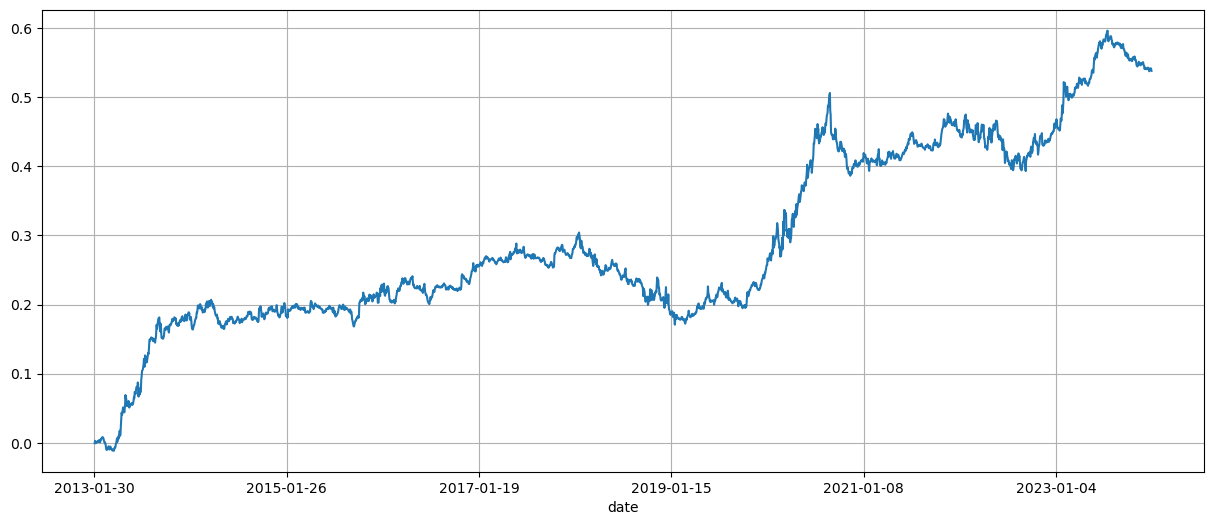

In [7]:
# simple visualization of cumulative log returns
daily_perf['daily_log_ret'].cumsum().plot(figsize=(15,6))
plt.grid()
plt.show()

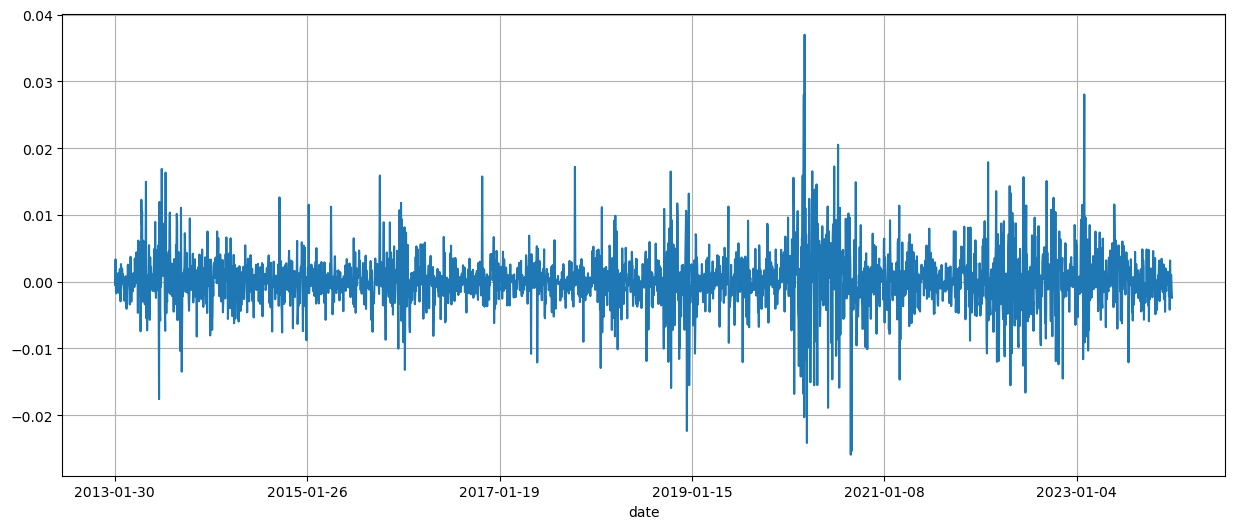

In [8]:
# simple visualization of daily log returns
daily_perf['daily_log_ret'].plot(figsize=(15,6))
plt.grid()
plt.show()

In [9]:
# testing with different position size
B = DoubleBollingerBand_Strategy(tickers, start_date, end_date, interval, initial_capital, True)
B.run_strategy(MA_window=20, BB1_deviation = 1, BB2_deviation = 2, position_size = 0.10) 
B.performance()

C = DoubleBollingerBand_Strategy(tickers, start_date, end_date, interval, initial_capital, True)
C.run_strategy(MA_window=20, BB1_deviation = 1, BB2_deviation = 2, position_size = 0.03) 
C.performance()

## The larger the position size (bigger fixed percentage of available capital), the higher total returns.
## However, max drawdown will also increase, and hence lower sharpe and sortino ratio

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Bought 44 shares of MSFT at 22.7 per share worth 999.7 $
Total quantity for MSFT is 44
Date :2013-01-30 | Realised Balance: 9000.3
Date :2013-01-30 | Unrealised Balance: 999.7
Date :2013-01-30 | Total Balance: 10000.0
--------
Sold 64 shares of AAPL at 13.9 per share worth 891.9 $
Total quantity for AAPL is -64
Date :2013-01-30 | Realised Balance: 9892.2
Date :2013-01-30 | Unrealised Balance: 107.8
Date :2013-01-30 | Total Balance: 10000.0
---------
Bought 52 shares of GOOG at 18.8 per share worth 976.3 $
Total quantity for GOOG is 52
Date :2013-01-30 | Realised Balance: 8915.8
Date :2013-01-30 | Unrealised Balance: 1084.2
Date :2013-01-30 | Total Balance: 10000.0
--------
Bought 356 shares of TSLA at 2.5 per share worth 890.5 $
Total quantity for TSLA is 356
Date :2013-01-30 | Realised Balance: 8025.4
Date :2013-01-30 | Unrealised Balance: 1974.6
Date :2013-01-30 | Total Balance: 10000.0
--------
Sold 61 shares of AMZN at 13.0 per share worth 792.9 $
Total quantity for AMZN is -61
Dat

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Bought 2 shares of NVDA at 500.7 per share worth 1001.5 $
Total quantity for NVDA is 0
Date :2023-12-18 | Realised Balance: 20672.7
Date :2023-12-18 | Unrealised Balance: 3216.5
Date :2023-12-18 | Total Balance: 23889.2
Bought 4 shares of NVDA at 500.7 per share worth 2003.0 $
Total quantity for NVDA is 4
Date :2023-12-18 | Realised Balance: 18669.7
Date :2023-12-18 | Unrealised Balance: 5219.5
Date :2023-12-18 | Total Balance: 23889.2
--------
Bought 5 shares of META at 344.3 per share worth 1721.3 $
Total quantity for META is 0
Date :2023-12-18 | Realised Balance: 16948.5
Date :2023-12-18 | Unrealised Balance: 6940.7
Date :2023-12-18 | Total Balance: 23889.2
Bought 4 shares of META at 344.3 per share worth 1377.0 $
Total quantity for META is 4
Date :2023-12-18 | Realised Balance: 15571.5
Date :2023-12-18 | Unrealised Balance: 8317.8
Date :2023-12-18 | Total Balance: 23889.2
--------
Bought 9 shares of GOOG at 139.7 per share worth 1256.9 $
Total quantity for GOOG is 0
Date :2023-12-2


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Bought 13 shares of MSFT at 22.7 per share worth 295.4 $
Total quantity for MSFT is 13
Date :2013-01-30 | Realised Balance: 9704.6
Date :2013-01-30 | Unrealised Balance: 295.4
Date :2013-01-30 | Total Balance: 10000.0
--------
Sold 20 shares of AAPL at 13.9 per share worth 278.7 $
Total quantity for AAPL is -20
Date :2013-01-30 | Realised Balance: 9983.3
Date :2013-01-30 | Unrealised Balance: 16.7
Date :2013-01-30 | Total Balance: 10000.0
---------
Bought 15 shares of GOOG at 18.8 per share worth 281.6 $
Total quantity for GOOG is 15
Date :2013-01-30 | Realised Balance: 9701.7
Date :2013-01-30 | Unrealised Balance: 298.3
Date :2013-01-30 | Total Balance: 10000.0
--------
Bought 116 shares of TSLA at 2.5 per share worth 290.2 $
Total quantity for TSLA is 116
Date :2013-01-30 | Realised Balance: 9411.6
Date :2013-01-30 | Unrealised Balance: 588.4
Date :2013-01-30 | Total Balance: 10000.0
--------
Sold 21 shares of AMZN at 13.0 per share worth 273.0 $
Total quantity for AMZN is -21
Date :

In [10]:
# testing with different bollinger band deviation
D = DoubleBollingerBand_Strategy(tickers, start_date, end_date, interval, initial_capital, True)
D.run_strategy(MA_window=20, BB1_deviation = 1, BB2_deviation = 3, position_size = 0.05) 
D.performance()

E = DoubleBollingerBand_Strategy(tickers, start_date, end_date, interval, initial_capital, True)
E.run_strategy(MA_window=20, BB1_deviation = 2, BB2_deviation = 3, position_size = 0.05) 
E.performance()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Bought 22 shares of MSFT at 22.7 per share worth 499.9 $
Total quantity for MSFT is 22
Date :2013-01-30 | Realised Balance: 9500.1
Date :2013-01-30 | Unrealised Balance: 499.9
Date :2013-01-30 | Total Balance: 10000.0
--------
Sold 34 shares of AAPL at 13.9 per share worth 473.8 $
Total quantity for AAPL is -34
Date :2013-01-30 | Realised Balance: 9973.9
Date :2013-01-30 | Unrealised Balance: 26.1
Date :2013-01-30 | Total Balance: 10000.0
---------
Bought 26 shares of GOOG at 18.8 per share worth 488.2 $
Total quantity for GOOG is 26
Date :2013-01-30 | Realised Balance: 9485.8
Date :2013-01-30 | Unrealised Balance: 514.2
Date :2013-01-30 | Total Balance: 10000.0
--------
Bought 189 shares of TSLA at 2.5 per share worth 472.8 $
Total quantity for TSLA is 189
Date :2013-01-30 | Realised Balance: 9013.0
Date :2013-01-30 | Unrealised Balance: 987.0
Date :2013-01-30 | Total Balance: 10000.0
--------
Sold 34 shares of AMZN at 13.0 per share worth 442.0 $
Total quantity for AMZN is -34
Date :

[*********************100%%**********************]  1 of 1 completed

Bought 3 shares of TSLA at 173.9 per share worth 521.6 $
Total quantity for TSLA is 0
Date :2023-05-17 | Realised Balance: 12454.4
Date :2023-05-17 | Unrealised Balance: 4115.5
Date :2023-05-17 | Total Balance: 16569.9
Bought 3 shares of TSLA at 173.9 per share worth 521.6 $
Total quantity for TSLA is 3
Date :2023-05-17 | Realised Balance: 11932.8
Date :2023-05-17 | Unrealised Balance: 4637.1
Date :2023-05-17 | Total Balance: 16569.9
--------
Sold 7 shares of GOOG at 121.3 per share worth 848.8 $
Total quantity for GOOG is 0
Date :2023-06-21 | Realised Balance: 12781.6
Date :2023-06-21 | Unrealised Balance: 4530.1
Date :2023-06-21 | Total Balance: 17311.7
Sold 5 shares of GOOG at 121.3 per share worth 606.3 $
Total quantity for GOOG is -5
Date :2023-06-21 | Realised Balance: 13387.9
Date :2023-06-21 | Unrealised Balance: 3923.8
Date :2023-06-21 | Total Balance: 17311.7
---------
Bought 5 shares of GOOG at 124.8 per share worth 624.2 $
Total quantity for GOOG is 0
Date :2023-07-13 | Rea


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Bought 25 shares of GOOG at 19.3 per share worth 482.9 $
Total quantity for GOOG is 25
Date :2013-02-01 | Realised Balance: 9517.1
Date :2013-02-01 | Unrealised Balance: 482.9
Date :2013-02-01 | Total Balance: 10000.0
--------
Sold 16 shares of META at 28.1 per share worth 449.3 $
Total quantity for META is -16
Date :2013-02-04 | Realised Balance: 9966.3
Date :2013-02-04 | Unrealised Balance: 23.3
Date :2013-02-04 | Total Balance: 9989.7
---------
Bought 169 shares of NVDA at 2.9 per share worth 496.5 $
Total quantity for NVDA is 169
Date :2013-02-14 | Realised Balance: 9469.8
Date :2013-02-14 | Unrealised Balance: 531.6
Date :2013-02-14 | Total Balance: 10001.4
--------
Sold 202 shares of TSLA at 2.3 per share worth 473.5 $
Total quantity for TSLA is -202
Date :2013-02-21 | Realised Balance: 9943.3
Date :2013-02-21 | Unrealised Balance: 65.2
Date :2013-02-21 | Total Balance: 10008.5
---------
Sold 38 shares of AAPL at 12.9 per share worth 489.7 $
Total quantity for AAPL is -38
Date :2